<a id="title"></a>

# Предсказание коэффициента восстановление золота из руды

## СОДЕРЖАНИЕ
<a id="title"></a>
* [План проекта](#plan)
* [Загрузка библиотек](#import_libs)  
* [Подготовка данных](#data_preparation)
    * [x] [Загрузка данных](#)
    * [x] [Первое впечатление](#first_impression)
    * [x] [Формала расчета эффективности обогощения](#recovery_func)
    * [x] [Признаки, недоступные в тестовой выборке](#not_in_test)
    * [x] [Предобработка данных](#predobarbotka)
* [Анализ данных](#analysis)
    * [x] [Концентрации металлов на различных стадиях](#concentrate)
    * [x] [Распределения размеров гранул сырья на обучающей и тестовой выборках](#train_vs_test_feeds)
    * [x] [Суммарная концентрация всех веществ на разных стадиях](#common_concentration)
* [Обучение модели](#fit_model)
    * [x] [Функция для вычисления итоговой sMAPE](#smape)
    * [x] [Обучение модели](#avg_rmse)
    * [x] [Проверим на тестовой модели](#check_test)

## План проекта

### Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Загрузка библиотек
<a id="import_lib"></a>
[go to the title](#title)

In [1]:
# импорт необходимых библиотек
import numpy as np
import scipy as sc
import pandas as pd
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
import seaborn as sb

## Подготовка данных
<a id="data_preparation"></a>
[go to the title](#title)

- [1.1. Откройте файлы и изучите их](#import_data)

     Путь к файлам:
    - /datasets/gold_recovery_train_new.csv.
    - /datasets/gold_recovery_test_new.csv.
    - /datasets/gold_recovery_full_new.csv.


- [1.2. Проверьте, что эффективность обогащения рассчитана правильно](#recovery_func)

    Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
   
   
- 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- 1.4. Проведите предобработку данных.


### Загрузка данных
<a id="import_data"></a>
[go to the title](#title)

In [2]:
# Загрузим датасет
try:
    train_df = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    test_df = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    full_df = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    train_df = pd.read_csv('gold_recovery_train_new.csv')
    test_df = pd.read_csv('gold_recovery_test_new.csv')
    full_df = pd.read_csv('gold_recovery_full_new.csv')

### Первое впечатление
<a id="first_impression"></a>
[go to the title](#title)

In [3]:
display(train_df.shape)
display(test_df.shape)
display(full_df.shape)

(14149, 87)

(5290, 53)

(19439, 87)

In [4]:
print(train_df.duplicated().sum())
print(train_df['date'].duplicated().sum())

0
0


In [5]:
# Посмотрим информацию по тренировочной выборке 
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


### Формула расчета эффективности обогощения
<a id="recovery_func"></a>
[go to the title](#title)

In [6]:
# Напишем функцию для расчета эффективности обогощения
# recovery = (c * (f - t) / f * (c - t)) * 100 
# C — доля золота в концентрате после флотации/очистки;
# F — доля золота в сырье/концентрате до флотации/очистки;
# T — доля золота в отвальных хвостах после флотации/очистки.

def recovery(df, columns_dict):
    c_name = columns_dict.get('C')
    f_name = columns_dict.get('F')
    t_name = columns_dict.get('T')
    
    c = np.array(df[c_name])
    f = np.array(df[f_name])
    t = np.array(df[t_name])
    
    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    
    recovery = pd.Series(recovery)
    return recovery
    
    

In [7]:
# Зададим через словарь названия колонок в датасете, соответствующих C, F и T - долям золота до, после и в хвостах
columns_dict = {}
columns_dict['C'] = 'rougher.output.concentrate_au'
columns_dict['F'] = 'rougher.input.feed_au'
columns_dict['T'] = 'rougher.output.tail_au'

# Посмотрим на в каком виде данные
print(list(columns_dict.values()))
display(train_df[list(columns_dict.values())].head())

# Рассчитаем при помощи нашей функции массив recovery
recovery_calc = recovery(train_df, columns_dict)



['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']


,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
0,19.793808,6.486150,1.170244
1,20.050975,6.478583,1.184827
2,19.737170,6.362222,1.162562
3,19.320810,6.118189,1.079755
4,19.216101,5.663707,1.012642


In [8]:
# Посмотрим на получившиеся значения
print('Первые 5 значений полученных по расчетам:')
display(recovery_calc.head())
# И на исходные
print('Первые 5 значений из исходной выборки:')
display(train_df['rougher.output.recovery'].head())

# Рассчитаем абсолютную среднюю ошибку
recovery_mae = mean_absolute_error(train_df['rougher.output.recovery'], recovery_calc)
print('Значение средней абсолютной ошибки:', recovery_mae)

Первые 5 значений полученных по расчетам:


0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
dtype: float64

Первые 5 значений из исходной выборки:


0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

Значение средней абсолютной ошибки: 9.73512347450521e-15


**Краткий вывод:** 
- По результатам расчетов можно сказать, что расхождения отсутствуют.
- данные корректные



### Признаки, недоступные в тестовой выборке.
Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

<a id="not_in_test"></a>
[go to the title](#title)

In [9]:
# Посмотрим какие признаки отсутствуют в тестовой выборке
# Создадим массивы с названиями колонок
train_columns_list = list(train_df.columns)
test_columns_list = list(test_df.columns)

# Найдем пересечение и проверим, все ли колонки из тестовой выборки есть в тренировочной
common_list = [column for column in test_columns_list if column in train_columns_list]
print('Все ли колонки из тестовой выборки есть в тренировочной:', common_list == test_columns_list, end='\n\n')

# Выделим те столбцы, которых нет в тестовой
only_train_columns_list = [column for column in train_columns_list if column not in test_columns_list]
print(train_df[only_train_columns_list].info())

Все ли колонки из тестовой выборки есть в тренировочной: True

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.

Отсутствуют данные финальных значений, данные всех выходных значений после каждого этапа и все расчетные параметры


In [10]:
# добавим в тестовую выборку столбцы с таргетом
columns = ['rougher.output.recovery', 'final.output.recovery', 'date' ]
test_df = test_df.merge(full_df[columns], how='left', on='date')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

### Предобработка данных
<a id="predobarbotka"></a>
[go to the title](#title)

In [11]:
# очистим данные от пустых значений
tr_df_clear = train_df.dropna()
print(tr_df_clear.shape)


# или же сделаем заполнение
tr_df_new = train_df.fillna(method='ffill', axis=0)
print(tr_df_new.shape)



(11017, 87)
(14149, 87)


## АНАЛИЗ ДАННЫХ
<a id="analysis"></a>
[go to the title](#title)

- 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
- 2.2.  Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
- 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

### Концентрации металлов на различных стадиях
<a id="concentrate"></a>
[go to the title](#title)

#### Концентрации золота на различных стадиях

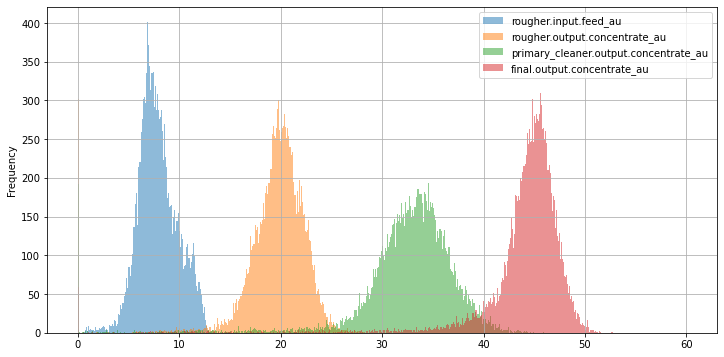

In [12]:
columns = ['rougher.input.feed_au'
           , 'rougher.output.concentrate_au'
           , 'primary_cleaner.output.concentrate_au'
           , 'final.output.concentrate_au']
ax = tr_df_new[columns].plot.hist(bins=600, figsize=(12, 6), alpha=0.5, range=(0, 60), grid=True)


In [13]:
for column in columns:
    print(f'Значения квантилей для параметра:{column}')
    print(f'Медиана = {round(tr_df_new[column].quantile(0.5), 2)}%')
    print(f'Первая четверть = {round(tr_df_new[column].quantile(0.25), 2)}%')
    print(f'Третья четверть = {round(tr_df_new[column].quantile(0.75), 2)}%', end='\n\n') 

Значения квантилей для параметра:rougher.input.feed_au
Медиана = 7.65%
Первая четверть = 6.6%
Третья четверть = 9.07%

Значения квантилей для параметра:rougher.output.concentrate_au
Медиана = 19.95%
Первая четверть = 18.43%
Третья четверть = 21.39%

Значения квантилей для параметра:primary_cleaner.output.concentrate_au
Медиана = 33.23%
Первая четверть = 30.86%
Третья четверть = 35.33%

Значения квантилей для параметра:final.output.concentrate_au
Медиана = 44.87%
Первая четверть = 43.28%
Третья четверть = 46.17%



#### Концентрация серебра на различных стадиях

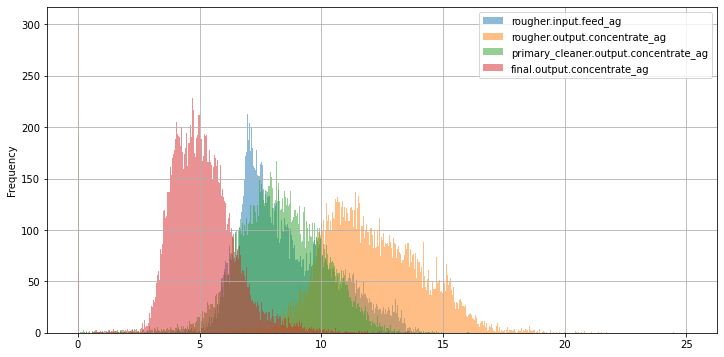

In [14]:
columns = ['rougher.input.feed_ag'
           , 'rougher.output.concentrate_ag'
           , 'primary_cleaner.output.concentrate_ag'
           , 'final.output.concentrate_ag']
ax = tr_df_new[columns].plot.hist(bins=600, figsize=(12, 6), alpha=0.5, grid=True, range=(0, 25))

In [15]:
for column in columns:
    print(f'Значения квантилей для параметра:{column}')
    print(f'Медиана = {round(tr_df_new[column].quantile(0.5), 2)}%')
    print(f'Первая четверть = {round(tr_df_new[column].quantile(0.25), 2)}%')
    print(f'Третья четверть = {round(tr_df_new[column].quantile(0.75), 2)}%', end='\n\n') 

Значения квантилей для параметра:rougher.input.feed_ag
Медиана = 8.16%
Первая четверть = 7.13%
Третья четверть = 9.92%

Значения квантилей для параметра:rougher.output.concentrate_ag
Медиана = 11.75%
Первая четверть = 10.49%
Третья четверть = 13.43%

Значения квантилей для параметра:primary_cleaner.output.concentrate_ag
Медиана = 8.23%
Первая четверть = 7.11%
Третья четверть = 9.5%

Значения квантилей для параметра:final.output.concentrate_ag
Медиана = 4.99%
Первая четверть = 4.21%
Третья четверть = 5.86%



#### Концентрация свинца на различных стадиях

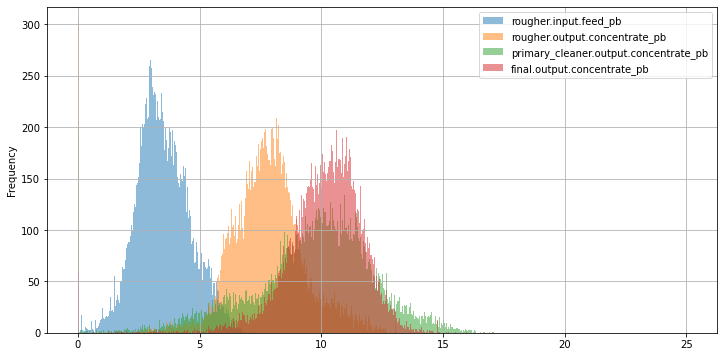

In [16]:
columns = ['rougher.input.feed_pb'
           , 'rougher.output.concentrate_pb'
           , 'primary_cleaner.output.concentrate_pb'
           , 'final.output.concentrate_pb']
ax = tr_df_new[columns].plot.hist(bins=600, figsize=(12, 6), alpha=0.5, grid=True, range=(0, 25))

In [17]:
for column in columns:
    print(f'Значения квантилей для параметра:{column}')
    print(f'Медиана = {round(tr_df_new[column].quantile(0.5), 2)}%')
    print(f'Первая четверть = {round(tr_df_new[column].quantile(0.25), 2)}%')
    print(f'Третья четверть = {round(tr_df_new[column].quantile(0.75), 2)}%', end='\n\n') 

Значения квантилей для параметра:rougher.input.feed_pb
Медиана = 3.41%
Первая четверть = 2.77%
Третья четверть = 4.22%

Значения квантилей для параметра:rougher.output.concentrate_pb
Медиана = 7.76%
Первая четверть = 6.85%
Третья четверть = 8.6%

Значения квантилей для параметра:primary_cleaner.output.concentrate_pb
Медиана = 9.92%
Первая четверть = 8.32%
Третья четверть = 11.3%

Значения квантилей для параметра:final.output.concentrate_pb
Медиана = 10.3%
Первая четверть = 9.3%
Третья четверть = 11.17%



#### Краткие выводы:
- Концентрация золота ожидаемо растет.
- Разброс концентраций в рамках этапа небольшой
- 

### Распределения размеров гранул сырья на обучающей и тестовой выборках
<a id="train_vs_test_feeds"></a>
[go to the title](#title)

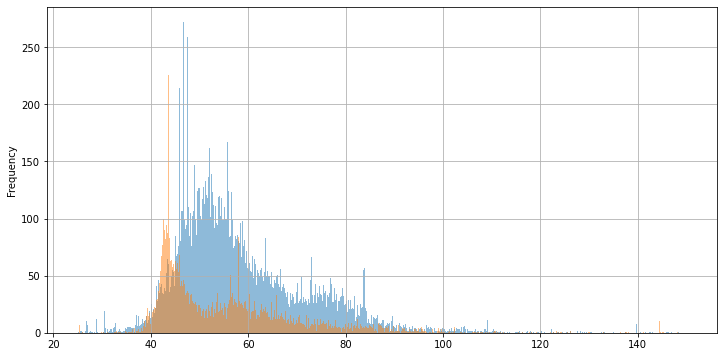

In [18]:
# Построим гистограммы распределения размеров гранул в исходном сырье для обучающей и тестовой выборки
train_df['rougher.input.feed_size'].plot.hist(bins=600, figsize=(12, 6), alpha=0.5, grid=True, range=(25, 150))
test_df['rougher.input.feed_size'].plot.hist(bins=600, figsize=(12, 6), alpha=0.5, grid=True, range=(25, 150))
# plt.title('гистограмма')
plt.show()

По графикам видно, что медианы распределений отличаются, но нет большого количества значений, которые были бы характерны для тестовой выборки и не присутствовали бы в обучающей. Так что у модели не должно возникнуть проблем при прогнозировании результатов на тестовой выборке.

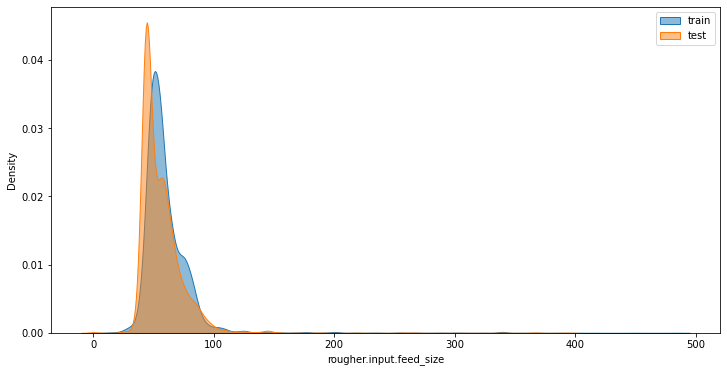

In [19]:
f, ax = plt.subplots(figsize=(12, 6))
sb.kdeplot(tr_df_new['rougher.input.feed_size']
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='train')
sb.kdeplot(test_df['rougher.input.feed_size']
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='test')
plt.legend(fontsize = 10)
plt.show()

Видны выбросы это значения ниже 10 и более 120

In [20]:
column = 'rougher.input.feed_size'
new_train = tr_df_new[(tr_df_new[column] > 20) & (tr_df_new[column] < 120)] 
new_test = test_df[(test_df[column] > 20) & (test_df[column] < 120)]

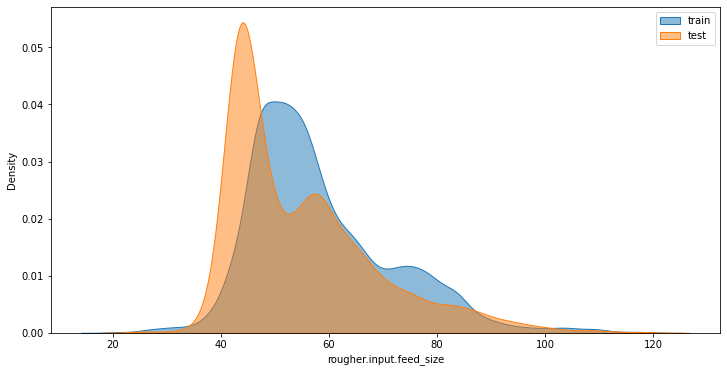

In [21]:
f, ax = plt.subplots(figsize=(12, 6))
sb.kdeplot(new_train['rougher.input.feed_size']
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='train')
sb.kdeplot(new_test['rougher.input.feed_size']
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='test')
plt.legend(fontsize = 10)
plt.show()

Much better

### Суммарная концентрация всех веществ на разных стадиях
<a id="common_concentration"></a>
[go to the title](#title)

In [22]:
# Просуммируем концентрации на различных стадиях
rougher_in = (tr_df_new['rougher.input.feed_au'] 
            + tr_df_new['rougher.input.feed_ag'] 
            + tr_df_new['rougher.input.feed_pb'] 
            + tr_df_new['rougher.input.feed_sol'])

rougher_out = (tr_df_new['rougher.output.concentrate_au'] 
            + tr_df_new['rougher.output.concentrate_ag'] 
            + tr_df_new['rougher.output.concentrate_pb'] 
            + tr_df_new['rougher.output.concentrate_sol'])

prime_out = (tr_df_new['primary_cleaner.output.concentrate_au'] 
            + tr_df_new['primary_cleaner.output.concentrate_ag'] 
            + tr_df_new['primary_cleaner.output.concentrate_pb'] 
            + tr_df_new['primary_cleaner.output.concentrate_sol'])

final_out = (tr_df_new['final.output.concentrate_au'] 
            + tr_df_new['final.output.concentrate_ag'] 
            + tr_df_new['final.output.concentrate_pb'] 
            + tr_df_new['final.output.concentrate_sol'])

In [23]:
# Сделаем общий датасет
df_common_concentration = pd.DataFrame(data = {'rougher_in': rougher_in
                                               , 'rougher_out': rougher_out
                                               , 'prime_out': prime_out
                                               , 'final_out': final_out})


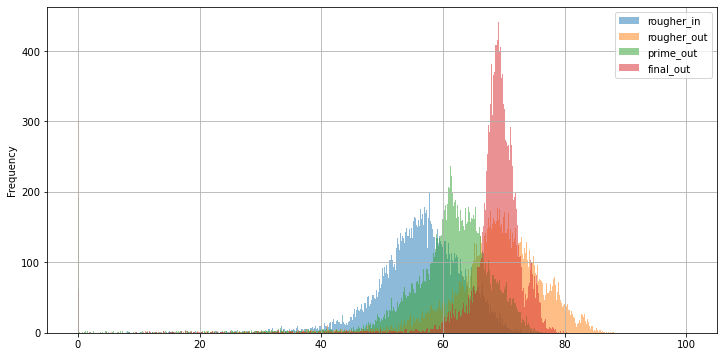

In [24]:
# Построим гистограмму для суммарной концентрации на различных стадиях
df_common_concentration.plot.hist(bins=600, figsize=(12, 6), alpha=0.5, grid=True, range=(0, 100))
plt.show()

In [25]:
for column in df_common_concentration:
    print(f'Значения квантилей для параметра:{column}')
    print(f'Медиана = {round(df_common_concentration[column].quantile(0.5), 2)}%')
    print(f'Первая четверть = {round(df_common_concentration[column].quantile(0.25), 2)}%')
    print(f'Третья четверть = {round(df_common_concentration[column].quantile(0.75), 2)}%', end='\n\n')

Значения квантилей для параметра:rougher_in
Медиана = 56.63%
Первая четверть = 52.57%
Третья четверть = 60.76%

Значения квантилей для параметра:rougher_out
Медиана = 69.18%
Первая четверть = 64.91%
Третья четверть = 73.43%

Значения квантилей для параметра:prime_out
Медиана = 61.79%
Первая четверть = 58.05%
Третья четверть = 65.36%

Значения квантилей для параметра:final_out
Медиана = 69.14%
Первая четверть = 67.56%
Третья четверть = 70.97%



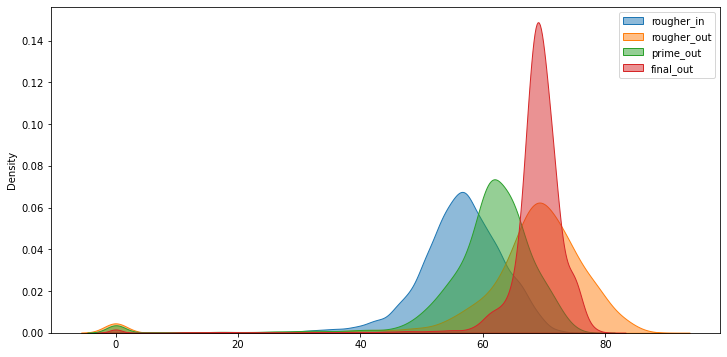

In [26]:
f, ax = plt.subplots(figsize=(12, 6))
sb.kdeplot(rougher_in
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='rougher_in')
sb.kdeplot(rougher_out
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='rougher_out')

sb.kdeplot(prime_out
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='prime_out')

sb.kdeplot(final_out
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='final_out')
plt.legend(fontsize = 10)
plt.show()

In [27]:
tr_df_new['rougher_in'] = rougher_in
tr_df_new['rougher_out'] = rougher_out
tr_df_new['prime_out'] = prime_out
tr_df_new['final_out'] = final_out

new_train_df = tr_df_new[tr_df_new['rougher_in'] > 30]
new_train_df = new_train_df[new_train_df['rougher_out'] > 30]
new_train_df = new_train_df[new_train_df['prime_out'] > 30]
new_train_df = new_train_df[new_train_df['final_out'] > 30]

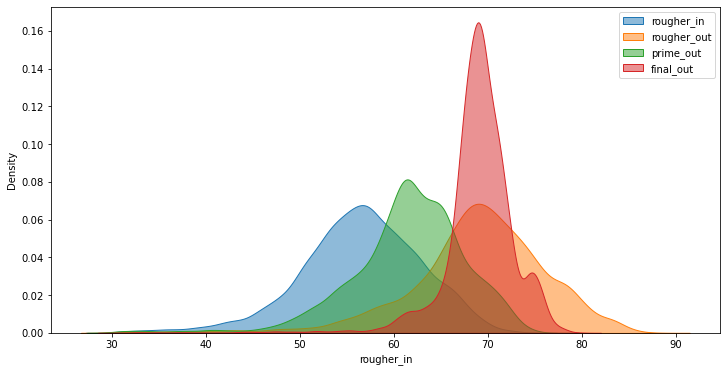

In [28]:
f, ax = plt.subplots(figsize=(12, 6))
sb.kdeplot(new_train_df['rougher_in']
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='rougher_in')
sb.kdeplot(new_train_df['rougher_out']
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='rougher_out')
sb.kdeplot(new_train_df['prime_out']
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='prime_out')
sb.kdeplot(new_train_df['final_out']
           , gridsize=500
#            , legend=True
           , bw_adjust=1
           , common_grid=True
           , fill=True
           , alpha=0.5
           , label='final_out')
plt.legend(fontsize = 10)
plt.show()

Выбросы убрали. Можно удалить ненужные столбцы.


In [29]:
new_train_df = new_train_df.drop(['rougher_in', 'rougher_out', 'prime_out', 'final_out'], axis=1)

## ОБУЧЕНИЕ МОДЕЛИ
<a id="fit_model"></a>
[go to the title](#title)

- 3.1. Напишите функцию для вычисления итоговой sMAPE.
- 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

### Функция для вычисления итоговой sMAPE
<a id="smape"></a>
[go to the title](#title)

In [30]:
# напишем функцию по расчету метрики sMAPE
def smape_calc(target, predict):
    smape = 100 * ((abs(target - predict) / ((abs(target) + abs(predict))/2)).mean())
    
    return smape


In [31]:
def ttl_smape(smape1, smape2):
    sMAPE = smape1 * 0.25 + smape2 * 0.75
    return sMAPE

### Обучаем первую модель

In [32]:
# зададим кастомную функцию оценки эффективности модели при кроссвалидации
sMAPE_custome_score = make_scorer(smape_calc, greater_is_better=False)

In [33]:
# Создадим выборки с признаками и таргетом
features_list = test_columns_list.copy()
features_list.remove('date')
features_train_df = new_train_df[features_list]
first_target_df = new_train_df['rougher.output.recovery']

features_train_df2 = tr_df_clear[features_list]
first_target_df2 = tr_df_clear['rougher.output.recovery']



In [34]:
%%time
# 
model1 = LinearRegression()
score1 = cross_val_score(model1, features_train_df, first_target_df, scoring=sMAPE_custome_score)

model2 = LinearRegression()
score2 = cross_val_score(model2, features_train_df2, first_target_df2, scoring=sMAPE_custome_score)

model3 = Lasso()
score3 = cross_val_score(model3, features_train_df, first_target_df, scoring=sMAPE_custome_score)

CPU times: user 3.15 s, sys: 353 ms, total: 3.5 s
Wall time: 529 ms


In [35]:
print('sMAPE для линейной регрессии на очищенной от выбросов выборке', score1.mean())
print('sMAPE для линейной регрессии на усеченной выборке', score2.mean())
print('sMAPE для Lasso на очищенной от выбросов выборке', score3.mean())

sMAPE для линейной регрессии на очищенной от выбросов выборке -7.230317834254227
sMAPE для линейной регрессии на усеченной выборке -11.925343594602728
sMAPE для Lasso на очищенной от выбросов выборке -6.954687473692401


In [36]:
%%time
# случайный лес на дополненной выборке
random_state = 12345
estimantors = 80
for depth in range(6, 12, 1):
    model = RandomForestRegressor(random_state=random_state, n_estimators=estimantors, max_depth=depth)
    score = cross_val_score(model, features_train_df, first_target_df, scoring=sMAPE_custome_score)

    print('Количество деревьев:', estimantors, '|', 'глубина:', depth, '|', 'sMAPE:',score.mean())

Количество деревьев: 80 | глубина: 6 | sMAPE: -6.224066824980069
Количество деревьев: 80 | глубина: 7 | sMAPE: -6.1936933822905305
Количество деревьев: 80 | глубина: 8 | sMAPE: -6.275245455812651
Количество деревьев: 80 | глубина: 9 | sMAPE: -6.31857238668466
Количество деревьев: 80 | глубина: 10 | sMAPE: -6.3275368137529835
Количество деревьев: 80 | глубина: 11 | sMAPE: -6.311048211291404
CPU times: user 7min 18s, sys: 1.05 s, total: 7min 19s
Wall time: 7min 18s


In [37]:
# %%time
# # случайный лес на очищеной выборке
# for depth in range(6, 12, 1):
#     model = RandomForestRegressor(random_state=random_state, n_estimators=estimantors, max_depth=depth)
#     score = cross_val_score(model, features_train_df2, first_target_df2, scoring=sMAPE_custome_score)

#     print('Количество деревьев:', 80, '|', 'глубина:', depth, '|', 'sMAPE:',score.mean())

In [38]:
%%time
depth = 7
for estimators in range(80, 200, 10):
    model = RandomForestRegressor(random_state=random_state, n_estimators=estimators, max_depth=depth)
    score = cross_val_score(model, features_train_df, first_target_df, scoring=sMAPE_custome_score)

    print('Количество деревьев:', estimators, '|', 'глубина:', depth, '|', 'sMAPE:',score.mean())

Количество деревьев: 80 | глубина: 7 | sMAPE: -6.1936933822905305
Количество деревьев: 90 | глубина: 7 | sMAPE: -6.2156544625993835
Количество деревьев: 100 | глубина: 7 | sMAPE: -6.197645993469254
Количество деревьев: 110 | глубина: 7 | sMAPE: -6.170186323357092
Количество деревьев: 120 | глубина: 7 | sMAPE: -6.188143577741138
Количество деревьев: 130 | глубина: 7 | sMAPE: -6.179035780466416
Количество деревьев: 140 | глубина: 7 | sMAPE: -6.169187415636273
Количество деревьев: 150 | глубина: 7 | sMAPE: -6.161004761002997
Количество деревьев: 160 | глубина: 7 | sMAPE: -6.144826982120529
Количество деревьев: 170 | глубина: 7 | sMAPE: -6.150354690618531
Количество деревьев: 180 | глубина: 7 | sMAPE: -6.154952782108016
Количество деревьев: 190 | глубина: 7 | sMAPE: -6.147707575311711
CPU times: user 21min 24s, sys: 1.81 s, total: 21min 25s
Wall time: 21min 52s


### Обучаем вторую модель

In [39]:
features_train_df = new_train_df[features_list]
second_target_df = new_train_df['final.output.recovery']

features_train_df2 = tr_df_clear[features_list]
second_target_df2 = tr_df_clear['final.output.recovery']

#### Линейная регрессия

In [40]:
%%time
# 
model1 = LinearRegression()
score1 = cross_val_score(model, features_train_df, second_target_df, scoring=sMAPE_custome_score)

model2 = LinearRegression()
score2 = cross_val_score(model2, features_train_df2, second_target_df2, scoring=sMAPE_custome_score)

model3 = Lasso()
score3 = cross_val_score(model3, features_train_df, second_target_df, scoring=sMAPE_custome_score)

CPU times: user 2min 36s, sys: 473 ms, total: 2min 37s
Wall time: 2min 34s


In [41]:
print('sMAPE для линейной регрессии на дополненной выборке', score1.mean())
print('sMAPE для линейной регрессии на усеченной выборке', score2.mean())
print('sMAPE для Lasso на дополненной выборке', score3.mean())

sMAPE для линейной регрессии на дополненной выборке -8.965486636716353
sMAPE для линейной регрессии на усеченной выборке -9.746081106190134
sMAPE для Lasso на дополненной выборке -10.302111012903016


In [42]:
%%time
# случайный лес на дополненной выборке
random_state = 12345
estimantors = 80
for depth in range(6, 12, 1):
    model = RandomForestRegressor(random_state=random_state, n_estimators=estimantors, max_depth=depth)
    score = cross_val_score(model, features_train_df, second_target_df, scoring=sMAPE_custome_score)

    print('Количество деревьев:', 80, '|', 'глубина:', depth, '|', 'sMAPE:', score.mean())

Количество деревьев: 80 | глубина: 6 | sMAPE: -8.898671872859275
Количество деревьев: 80 | глубина: 7 | sMAPE: -9.001355565729714
Количество деревьев: 80 | глубина: 8 | sMAPE: -9.09032241477036
Количество деревьев: 80 | глубина: 9 | sMAPE: -9.085459811543226
Количество деревьев: 80 | глубина: 10 | sMAPE: -9.197491899606012
Количество деревьев: 80 | глубина: 11 | sMAPE: -9.226627631493315
CPU times: user 7min 34s, sys: 921 ms, total: 7min 34s
Wall time: 7min 34s


In [43]:
%%time
depth = 6
for estimators in range(80, 200, 10):
    model = RandomForestRegressor(random_state=random_state, n_estimators=estimators, max_depth=depth)
    score = cross_val_score(model, features_train_df, second_target_df, scoring=sMAPE_custome_score)

    print('Количество деревьев:', estimators, '|', 'глубина:', depth, '|', 'sMAPE:',score.mean())

Количество деревьев: 80 | глубина: 6 | sMAPE: -8.898671872859275
Количество деревьев: 90 | глубина: 6 | sMAPE: -8.876345726165972
Количество деревьев: 100 | глубина: 6 | sMAPE: -8.866945654902018
Количество деревьев: 110 | глубина: 6 | sMAPE: -8.842330645474352
Количество деревьев: 120 | глубина: 6 | sMAPE: -8.836097598979823
Количество деревьев: 130 | глубина: 6 | sMAPE: -8.851587415242898
Количество деревьев: 140 | глубина: 6 | sMAPE: -8.849440644834994
Количество деревьев: 150 | глубина: 6 | sMAPE: -8.84304022230447
Количество деревьев: 160 | глубина: 6 | sMAPE: -8.832897187424516
Количество деревьев: 170 | глубина: 6 | sMAPE: -8.836870167440544
Количество деревьев: 180 | глубина: 6 | sMAPE: -8.852080879195917
Количество деревьев: 190 | глубина: 6 | sMAPE: -8.852200970534973
CPU times: user 19min 4s, sys: 1.52 s, total: 19min 5s
Wall time: 19min 5s


### Проверим модели на тестовой выборке:

In [44]:
%%time
# 
# features_train_df = new_train_df[features_list]
# first_target_df = new_train_df['rougher.output.recovery']
# second_target_df = new_train_df['final.output.recovery']

model_1 = RandomForestRegressor(random_state=random_state, n_estimators=120, max_depth=7)
model_2 = RandomForestRegressor(random_state=random_state, n_estimators=120, max_depth=6)

model_1.fit(features_train_df, first_target_df)
model_2.fit(features_train_df, second_target_df)

CPU times: user 45.7 s, sys: 62.2 ms, total: 45.7 s
Wall time: 45.7 s


RandomForestRegressor(max_depth=6, n_estimators=120, random_state=12345)

In [45]:
features_test = test_df.dropna()[features_list]
predicted_tests_1 = model_1.predict(features_test)
predicted_tests_2 = model_2.predict(features_test)


In [46]:
first_target_test = test_df.dropna()['rougher.output.recovery']
second_target_test = test_df.dropna()['final.output.recovery']
sMAPE_1 = smape_calc(predicted_tests_1, first_target_test)
sMAPE_2 = smape_calc(predicted_tests_2, second_target_test)

# sMAPE = 0.25 * sMAPE_1 + 0.75 * sMAPE_2

In [47]:
print('Итоговый sMAPE:', ttl_smape(sMAPE_1, sMAPE_2))

Итоговый sMAPE: 8.843709121066748


In [48]:
from sklearn.dummy import DummyRegressor

dummy_regr_1 = DummyRegressor(strategy="median")
dummy_regr_1.fit(features_train_df, first_target_df)


dummy_regr_2 = DummyRegressor(strategy="median")
dummy_regr_2.fit(features_train_df, second_target_df)

DummyRegressor(strategy='median')

In [49]:
predicted_dummy_1 = dummy_regr_1.predict(features_test)
predicted_dummy_2 = dummy_regr_2.predict(features_test)

sMAPE_1_dummy = smape_calc(predicted_dummy_1, first_target_test)
sMAPE_2_dummy = smape_calc(predicted_dummy_2, second_target_test)

In [50]:
print('Итоговый sMAPE для Dummy модели:', ttl_smape(sMAPE_1_dummy, sMAPE_2_dummy))

Итоговый sMAPE для Dummy модели: 9.023425169606455
